# Control of a "spacecraft" platform with a reaction wheel

## Set up simulation

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
from scipy import linalg
import sympy as sym
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_platform

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_platform)

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create an instance of the robot simulator. This will open a window in which you should see the reaction wheel.

There are four optional parameters:

* `damping` is the coefficient of viscous friction at each joint (the default value is `0.`)
* `pitch` is the angle of the ground in radians (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.001`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
robot = ae353_platform.RobotSimulator(damping=0., pitch=0., dt=0.01, display=True)

## Do control design and analysis

Define state space model:

$$
A = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}
\qquad
B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}
$$

This assumes the state and input are defined as

$$
x = \begin{bmatrix} q - q_e \\ v - v_e \end{bmatrix}
\qquad
u = \begin{bmatrix} \tau_{\text{platform}} - \tau_{\text{platform}, e} \end{bmatrix}
$$

where $\tau$ is the torque applied to the wheel and $\tau_{\text{platform}} = -\tau$ is the equivalent torque applied to the platform.

In [2]:
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0.], [1.]])

Choose $K$ by hand from calculation in class:

In [3]:
K = np.array([[6., 5.]])

Choose $K$ automatically using `place_poles` and see if we get the same answer:

In [10]:
from scipy import signal

In [11]:
stuff = signal.place_poles(A, B, [-2., -3.])

In [12]:
K = stuff.gain_matrix

In [13]:
K

array([[6., 5.]])

In [ ]:
def place(A, B, p):
    stuff = signal.place_poles(A, B, p)
    return stuff.gain_matrix

In [22]:
stuff = signal.place_poles(A, B, [-1., -1.])
K = stuff.gain_matrix
print(K)

ValueError: at least one of the requested pole is repeated more than rank(B) times

In [21]:
s = linalg.eigvals(A - B @ K)
print(s)

[-1.+2.j -1.-2.j]


In [28]:
# K = np.array([[0., 0.]])
# K = np.array([[10., 7.]])
# K = np.array([[50., 10.]])
K = np.array([[169., 10.]])
# K = np.array([[-6., 1.]])
# K = np.array([[1., 2.]])

Find closed-loop system:

$$ F = A - B K $$

In [4]:
F = A - B @ K
print(F)

[[ 0.  1.]
 [-6. -5.]]


Find eigenvalues of closed-loop system:

In [5]:
s = linalg.eigvals(F)
print(s)

[-2.+0.j -3.+0.j]


Find:

* a matrix $S$ with eigenvalues in each diagonal entry
* a matrix $V$ with the corresponding eigenvectors in each column

In [34]:
s, V = linalg.eig(F)
S = np.diag(s)
print(S)
print(V)

[[-5.+12.j  0. +0.j]
 [ 0. +0.j -5.-12.j]]
[[-0.02949865-0.07079677j -0.02949865+0.07079677j]
 [ 0.99705449+0.j          0.99705449-0.j        ]]


Show that

$$V^{-1} F V = S = \text{diag}(s_1, s_2)$$

In [35]:
print(linalg.inv(V) @ F @ V)

[[-5.+12.j -0. -0.j]
 [-0. +0.j -5.-12.j]]


Show that

$$e^{Ft}x_0 = V e^{V^{-1}FVt} V^{-1} x_0$$

In [36]:
# Choose a time and an initial condition for this example
t = 0.1
x0 = np.array([[1.], [-2.]])

# Compute solution the normal way
print(linalg.expm(F * t) @ x0)

# Compute solution by diagonalization
print(V @ linalg.expm(linalg.inv(V) @ F @ V * t) @ linalg.inv(V) @ x0)
# print((V @ linalg.expm(linalg.inv(V) @ F @ V * t) @ linalg.inv(V) @ x0).real)

[[ 0.36110866]
 [-7.92992341]]
[[ 0.36110866+0.j]
 [-7.92992341-0.j]]


Find solution at arbitrary time for arbitrary initial condition:

$$ x(t) = e^{Ft} x(0) $$

In [37]:
# Symbolic variables
t, x1_0, x2_0 = sym.symbols('t, x1_0, x2_0', real=True)

# Closed-loop system (symbolic)
F = sym.nsimplify(sym.Matrix(F), rational=True)

# Initial condition (symbolic)
x0 = sym.Matrix([[x1_0], [x2_0]])

# Solution (symbolic)
sym.exp(F * t) @ x0
# sym.simplify(sym.exp(F * t) @ x0)
# sym.simplify(sym.exp(F * t) @ x0).expand()

Matrix([
[      x1_0*(5*exp(-5*t)*sin(12*t)/12 + exp(-5*t)*cos(12*t)) + x2_0*exp(-5*t)*sin(12*t)/12],
[-169*x1_0*exp(-5*t)*sin(12*t)/12 + x2_0*(-5*exp(-5*t)*sin(12*t)/12 + exp(-5*t)*cos(12*t))]])

## Do implementation

Define and create an instance of the robot controller. By default, it chooses to apply zero torque to the wheel. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [31]:
class RobotController:
    def __init__(self, dt=0.01, K=np.array([[0., 0.]])):
        self.dt = dt
        
        # Choose equilibrium point
        self.q_e = 0.5 * np.pi
        self.v_e = 0.
        self.tau_e = 0.
        
        # Choose state feedback gains
        self.K = K
        
    
    def run(self, q, v, q_wheel, v_wheel):
        """
        INPUTS
         q = angle of platform (rad)
         v = angular velocity of platform (rad/s)
         q_wheel = angle of wheel with respect to platform (rad)
         v_wheel = angular velocity of wheel with respect to platform (rad/s)
        
        OUTPUTS
         tau = torque applied to wheel by motor on platform (N m)
        """
        
        # find x
        x = np.array([[q - self.q_e], [v - self.v_e]])
        
        # find u
        u = - self.K @ x
        
        # find the torque that we want applied to the platform
        tau_on_platform = u[0, 0] + self.tau_e
        
        # find the torque that would have to be applied to the wheel
        tau = - tau_on_platform
        
        return tau

controller = RobotController(dt=robot.dt, K=K)

Run the simulation. It is a loop. At each iteration, we:
* get a sensor measurement
* choose an actuator command
* go forward one time step

We also log data so that we can plot it later, if we want.

In [32]:
# Restore the simulation to its initial state
#
# - could also use:
#
#       robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))
#
#   for some choice of initial joint angles q_platform and q_wheel
#   and initial joint velocities v_platform and v_wheel
#
robot.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q, v, q_wheel, v_wheel = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q, v, q_wheel, v_wheel)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q
    data['v'][step] = v
    data['q_wheel'][step] = q_wheel
    data['v_wheel'][step] = v_wheel
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

Plot the results.

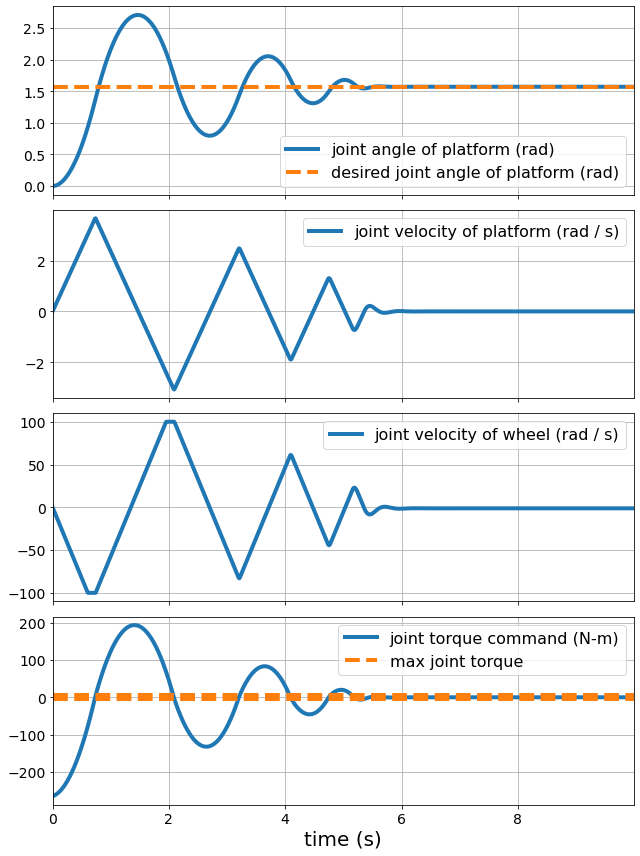

In [33]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# Plot joint angle of platform on first subplot
ax[0].plot(data['t'], data['q'], label='joint angle of platform (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * controller.q_e, '--', label='desired joint angle of platform (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot joint velocity of platform on second subplot
ax[1].plot(data['t'], data['v'], label='joint velocity of platform (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot joint velocity of wheel on third subplot
ax[2].plot(data['t'], data['v_wheel'], label='joint velocity of wheel (rad / s)', linewidth=4)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Plot joint torque on fourth subplot
ax[3].plot(data['t'], data['tau'], label='joint torque command (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C1')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

# Calculations

Choose platform mass so the state space model is simple.

In [ ]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

print(f'mp = {mp}')
print(f'Jp = {Jp} ({(1. / 12.) * mp * (3.**2 + 0.2**2)}, {(1. / 12.) * mp * (2.**2 + 0.2**2)})')
print(f'mw = {mw}')
print(f'Jw = {Jw} ({(1. / 12.) * mw * (3. * rw**2 + 0.2**2)})')
print(f'Jp + mw * l**2 = {Jp + mw * l**2}')